# ATLAS Open Data Analysis in Python

In [1]:
try:
    import import_ipynb
except:
    !pip install import_ipynb

This notebook will show an example on how one can read all of the ROOT files available in the 13 TeV ATLAS Open Data release, select the events one is interested in (here we will focus on events with exactly four leptons), create some histograms and write files to hdf5 for later use in e.g. machine learning. The notebook uses the Awkward Array data structures. This can be thought of as equivalent to Numpy for ragged data.

In [2]:
import pathlib
# Set whether to use Dask or not
doDask = False
n_workers = 64 # Only relevant if Dask is used

# Imports
import time
import numpy as np
import os

# Import uproot
import uproot

# Import Awkward Array or Dask-awkward, depending on the setting above
if doDask:
    import dask_awkward as ak
else:
    import awkward as ak

# Import Pandas
import pandas as pd

# for MT2
from mt2 import mt2

/tmp/ipykernel_27/93716355.py:21: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Check the input

In [3]:
import import_ipynb
from OpenDataPandaFramework13TeV import *

importing Jupyter notebook from OpenDataPandaFramework13TeV.ipynb
This library contains handy functions to ease the access and use of the 13TeV ATLAS OpenData release

getBkgCategories()
	 Dumps the name of the various background cataegories available 
	 as well as the number of samples contained in each category.
	 Returns a vector with the name of the categories

getSamplesInCategory(cat)
	 Dumps the name of the samples contained in a given category (cat)
	 Returns dictionary with keys being DSIDs and values physics process name from filename.

getMCCategory()
	 Returns dictionary with keys DSID and values MC category

initialize(indir)
	 Collects all the root files available in a certain directory (indir)

getSkims(indir)
	 Prints all available skims in the directory



Setting luminosity to 10064 pb^-1

###############################
#### Background categories ####
###############################
Category             N(samples)
-------------------------------
Diboson              

In [4]:
getSkims("/storage/shared/data/fys5555/ATLAS_opendata/")

1largeRjet1lep
1lep
1lep1tau
2lep
3lep
4lep
GamGam
exactly2lep
records


In [5]:
skim = "exactly2lep"
path = "/storage/shared/data/fys5555/ATLAS_opendata/"+skim+"/MC/"
sample_dic = initialize(path)
path = "/storage/shared/data/fys5555/ATLAS_opendata/"+skim+"/Data/"
sample_dic = {**sample_dic,**initialize(path)}

####################################################################################################
SIGNAL SAMPLES
####################################################################################################
WARNING 	 File for C1N2_WZ_350p0_0p0_3L_2L7 not found in /storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC/
WARNING 	 File for C1N2_WZ_400p0_0p0_3L_2L7 not found in /storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC/
WARNING 	 File for C1N2_WZ_100p0_0p0_3L_2L7 not found in /storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC/
WARNING 	 File for C1N2_WZ_500p0_0p0_3L_2L7 not found in /storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC/
WARNING 	 File for RS_G_ZZ_llll_c10_m1000 not found in /storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC/
WARNING 	 File for RS_G_ZZ_llll_c10_m2000 not found in /storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC/
WARNING 	 File for RS_G_ZZ_llll_c10_m0200 not found in /storage/shared/data/fys5555/A

In [6]:
sample_dic

{'topX': {'files': ['/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_410155.ttW.exactly2lep.root',
   '/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_410218.ttee.exactly2lep.root',
   '/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_410219.ttmumu.exactly2lep.root'],
  'type': 'bkg',
  'dsid': ['410155', '410218', '410219']},
 'Gmumu': {'files': ['/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_305574.Gmumu_01_2000.exactly2lep.root',
   '/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_305577.Gmumu_01_3000.exactly2lep.root',
   '/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_305580.Gmumu_01_4000.exactly2lep.root',
   '/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_305568.Gmumu_01_750.exactly2lep.root',
   '/storage/shared/data/fys5555/ATLAS_opendata/exactly2lep/MC//mc_305571.Gmumu_01_1000.exactly2lep.root'],
  'type': 'signal',
  'dsid': ['305574', '305577', '305580', '305568', '30

In [7]:
bkgs = getBkgCategories()
#bkgs.remove("Wjets")
bkgs.remove("Wjetsincl")
bkgs.remove("Zjetsincl")
#bkgs.remove("Zjets")
bkgs.remove("Higgs4L")
requiredProcesses = bkgs + ["data"] + ["SUSYC1C1"] 
print(requiredProcesses)



###############################
#### Background categories ####
###############################
Category             N(samples)
-------------------------------
Diboson                      10
Higgs                        16
Higgs4L                       4
Wjets                        42
Wjetsincl                     6
Zjets                        42
Zjetsincl                     3
singleTop                     6
topX                          3
ttbar                         1
['Diboson', 'Higgs', 'Wjets', 'Zjets', 'singleTop', 'topX', 'ttbar', 'data', 'SUSYC1C1']


## Define some functions

We need to define some helpful python functions for running with Dask (multi processing) and creating histograms.

In [8]:
hadded_dir = "/storage/shared/data/fys5555/ATLAS_opendata_hadded/"+skim+"/"
path = pathlib.Path(hadded_dir)
path.mkdir(parents=True, exist_ok=True)

for process in bkgs + ["data"] + ["SUSYC1C1"]:
    target = hadded_dir+"/"+process+".root"
    if os.path.exists(target):
        print("File %s exists already. Skipping"%target)
        continue
    source = " ".join(sample_dic[process]['files'])
    
    haddstr = "hadd %s %s" %(target,source)
    os.system(haddstr)

File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//Diboson.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//Higgs.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//Wjets.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//Zjets.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//singleTop.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//topX.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//ttbar.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//data.root exists already. Skipping
File /storage/shared/data/fys5555/ATLAS_opendata_hadded/exactly2lep//SUSYC1C1.root exists already. Skipping


In [9]:
# Open the files and create the data structures. If you are running Dask, nothing will happen at this 
# stage (lazy execution)
doDask = False
events = {}
for process in bkgs + ["data"] + ["SUSYC1C1"]:
    print(process)
    read_dic = {}
    inputString = hadded_dir+process+".root:mini"
    if doDask:        
        events[process] = uproot.dask(inputString,
                                      library="ak",
                                      open_files=False)
    else:
        events[process] = uproot.open(inputString)

Diboson
Higgs
Wjets
Zjets
singleTop
topX
ttbar
data
SUSYC1C1


At a certain point in the analysis we’ll also need to compute the invariant mass, and a specialised variable called MT2, for pairs of partices. These two methods implement this using external libraries that have been written by members of the high energy physics community.

In [10]:
##for 2lep case
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of ee, mm, em
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1]
    return (sum_lep_type != 22) & (sum_lep_type != 26) & (sum_lep_type != 24) 
    


In [11]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M

def calc_mll(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 2 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1]).M


def calc_m2lep():
    
    return



In [12]:
# Python method for computing MT2
# Uses the mt2 library
# Note this is vectorised...
def ComputeMT2(pts1,pts2,etas1,etas2,phis1,phis2,masses1,masses2,neutrino_pt,neutrino_phi):
    px1 = pts1 * np.cos(phis1)
    py1 = pts1 * np.sin(phis1)
    px2 = pts2 * np.cos(phis2)
    py2 = pts2 * np.sin(phis2)
    mpx = neutrino_pt * np.cos(neutrino_phi)
    mpy = neutrino_pt * np.sin(neutrino_phi)
    return mt2(masses1,px1,py1,masses2,px2,py2,mpx,mpy,0,0)

In [13]:
# Function to build a record from the list of variable names
def buildRecord(awkwardEvents,variableDict):
    theDict = {}
    for key in variableDict.keys():
        if doDask: 
            theDict[key] = awkwardEvents[variableDict[key]]
        else:
            theDict[key] = awkwardEvents[variableDict[key]].array()
    return ak.zip(theDict,depth_limit=1)

## Getting and preparing the input

In this part we look more closely at the content of the open data.

First we list all of the variables that are in the input files.

In [14]:
print("%-30s %-50s"%("Variable Name","Size/dim/type"))
for var in events['SUSYC1C1'].keys():
    print("%-30s %-50s"%(var,events['SUSYC1C1'][var].array().type))

Variable Name                  Size/dim/type                                     
runNumber                      137944 * int32                                    
eventNumber                    137944 * int32                                    
channelNumber                  137944 * int32                                    
mcWeight                       137944 * float32                                  
scaleFactor_PILEUP             137944 * float32                                  
scaleFactor_ELE                137944 * float32                                  
scaleFactor_MUON               137944 * float32                                  
scaleFactor_PHOTON             137944 * float32                                  
scaleFactor_TAU                137944 * float32                                  
scaleFactor_BTAG               137944 * float32                                  
scaleFactor_LepTRIGGER         137944 * float32                                  
scaleFactor_Phot

In [15]:
channelnumber = events['SUSYC1C1']['channelNumber'].array()
print(channelnumber)

lepton_pt = events['SUSYC1C1']['lep_pt'].array()
# Counting...
print("Number of rows = ",len(lepton_pt))
print("Number of lepton in each row = ", ak.count(lepton_pt, axis=1))
print("Total number of leptons = ", ak.count(lepton_pt, axis=None))
print("Average leptons per event (multiplicity) = ",ak.count(lepton_pt, axis=None)/len(lepton_pt))

[392518, 392518, 392518, 392518, 392518, ..., 392521, 392521, 392521, 392521]
Number of rows =  137944
Number of lepton in each row =  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..., 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Total number of leptons =  275888
Average leptons per event (multiplicity) =  2.0


We then makes life easier for us by defining useful names for the variables available for each type of particle.

In [16]:
lepton_variables = {'n':'lep_n', 
                    'truthMatched': 'lep_truthMatched',                                
                    'trigMatched': 'lep_trigMatched',                                 
                    'pt': 'lep_pt',                                          
                    'eta': 'lep_eta',                                         
                    'phi': 'lep_phi',                                         
                    'E': 'lep_E',                                           
                    'z0': 'lep_z0',                                          
                    'charge': 'lep_charge',                                      
                    'pdgid': 'lep_type',                                        
                    'isTightID': 'lep_isTightID',                                   
                    'ptcone30': 'lep_ptcone30',                                    
                    'etcone20': 'lep_etcone20',                                    
                    'trackd0pvunbiased': 'lep_trackd0pvunbiased',                           
                    'tracksigd0pvunbiased': 'lep_tracksigd0pvunbiased',  
                    }
jet_variables = {'n': 'jet_n',                                           
                 'pt': 'jet_pt',                                            
                 'eta': 'jet_eta',                                           
                 'phi': 'jet_phi',                                           
                 'E': 'jet_E',                                             
                 'jvt': 'jet_jvt',                                           
                 'trueflav': 'jet_trueflav',                                      
                 'truthMatched': 'jet_truthMatched',                                  
                 'MV2c10': 'jet_MV2c10'
                 }

event_variables = {'mcw':'mcWeight',
                   'sf_pu':'scaleFactor_PILEUP',
                   'sf_el':'scaleFactor_ELE',
                   'sf_mu':'scaleFactor_MUON',
                   'sf_ph':'scaleFactor_PHOTON',
                   'sf_ta':'scaleFactor_TAU',
                   'sf_bt':'scaleFactor_BTAG',
                   'sf_lt':'scaleFactor_LepTRIGGER',
                   'sf_pt':'scaleFactor_PhotonTRIGGER',
                   'runNumber':'runNumber',                                       
                   'eventNumber':'eventNumber',                                     
                   'channelNumber':'channelNumber',
                   'trigE':'trigE',
                   'trigM':'trigM',            
                   'trigP':'trigP',
                   'SumWeights':'SumWeights',
                   'xsec':'XSection'}


largeRjet_variables={ 
    'n':'largeRjet_n',
    'pt':'largeRjet_pt',
    'eta':'largeRjet_eta',
    'phi':'largeRjet_phi',
    'E':'largeRjet_E',
    'm':'largeRjet_m',
    'truthMatched':'largeRjet_truthMatched',
    'D2':'largeRjet_D2',
    'tau32':'largeRjet_tau32',
    'pt_syst':'largeRjet_pt_syst'}


met_variables = {'et':'met_et',
                 'phi':'met_phi'} 
all_variables = []
for dictionary in lepton_variables,jet_variables,largeRjet_variables,met_variables, event_variables :
    all_variables += dictionary.values()

print(all_variables)

['lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_jvt', 'jet_trueflav', 'jet_truthMatched', 'jet_MV2c10', 'largeRjet_n', 'largeRjet_pt', 'largeRjet_eta', 'largeRjet_phi', 'largeRjet_E', 'largeRjet_m', 'largeRjet_truthMatched', 'largeRjet_D2', 'largeRjet_tau32', 'largeRjet_pt_syst', 'met_et', 'met_phi', 'mcWeight', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER', 'runNumber', 'eventNumber', 'channelNumber', 'trigE', 'trigM', 'trigP', 'SumWeights', 'XSection']


## The Analysis

We have now defined the location of all the input files, setup single threaded or Dask and looked the columns/variables. We are then ready to start processing all the events in all of the input files.

In this example we will loop over each input file and launch processes for each one. Technically, this isn’t necessary - we could process them all together monolithically and avoid the loop. We do it for cosmetic reasons: when we make the final histograms, we want them to be stacked with a different colour for each kind of process, so that it can be clearly seen where in the distributions the different processes are important. To correctly set the colours in the plots, we therefore loop over each file. Note that this could also be achieved by writing the name of the process as a new column within each file.

Below we will do basically two things on each of the input files:

1. Define new arrays (augmentation)

1. Define some selections by filtering out the events we are interested in (slimming)

**Note**: If you are running with doDask set to true, nothing will be computed here - all that will happen is the computational graph will be constructed (lazy execution). If doDask is false computation will happen here (eager execution).

In [17]:
# Set up easy-to-use data structures
leptons = {}
jets = {}
taus = {}
photons = {}
largeRjets = {}
met = {}
eventLevel = {}

for process in events.keys():
    print(process)
    leptons[process] = buildRecord(events[process],lepton_variables)
    jets[process] = buildRecord(events[process],jet_variables)
    #taus[process] = buildRecord(events[process],tau_variables)
    #photons[process] = buildRecord(events[process],photon_variables)
    largeRjets[process] = buildRecord(events[process],largeRjet_variables)
    met[process] = buildRecord(events[process],met_variables)
    eventLevel[process] = buildRecord(events[process],event_variables)


print(leptons['SUSYC1C1'])
#the channel numbers is in eventLevel[proess] 

Diboson
Higgs
Wjets
Zjets
singleTop
topX
ttbar
data
SUSYC1C1
[{n: 2, truthMatched: [False, False], trigMatched: [...], pt: [...], ...}, ...]


In [18]:
lumi

10064.0

In [20]:
# Define selections
# Create a new dictionary which will contain our filtered 
# data, with the keys indicating the selection and the name.
selection = {}
for process in events.keys():
    
    print(process)
    
    selection[process] = {}

    # These functions make sure that the leptons have opposite charge 
    #(i.e there are two pairs of opposite sign leptons)
    leptons[process] = leptons[process][~cut_lep_charge(leptons[process].charge)]
    # And that there are either 2 electrons, 2 muons (or 1 electrons and 1 muons?)
    leptons[process] = leptons[process][~cut_lep_type(leptons[process].pdgid)]
    

    selection[process][("2L","channel_nr")] = eventLevel[process].channelNumber
    selection[process][("2L","type")] = leptons[process].pdgid
    selection[process][("2L","et")] = met[process].et
    selection[process][("2L","phi")] = met[process].phi
    
    selection[process][("2L","jet_n")] = jets[process].n 

    
    #selection[process][("2L","jet_pt")] = jets[process].pt #this might not have a value

    

    
    


    
    
    
    selection[process][("2L","sig_el")] = (leptons[process].pdgid == 11) & (leptons[process].eta > -2.47) \
                                            & (leptons[process].eta < 2.47) & (leptons[process].pt > 7000.0) \
                                            & (leptons[process].etcone20/leptons[process].pt < 0.15) & leptons[process].isTightID
    selection[process][("2L","sig_mu")] = (leptons[process].pdgid == 13) & (leptons[process].eta > -2.7) \
                                            & (leptons[process].eta < 2.7) & (leptons[process].pt > 7000.0) \
                                            & (leptons[process].etcone20/leptons[process].pt < 0.15)
    
    if not "data" in process:
        eventLevel[process]["scalef"] = ((lumi*eventLevel[process].xsec*eventLevel[process].mcw*eventLevel[process].sf_pu*eventLevel[process].sf_el* \
                                           eventLevel[process].sf_mu*eventLevel[process].sf_lt)/(eventLevel[process].SumWeights))
    else:
        eventLevel[process]["scalef"] = ak.full_like(eventLevel[process].xsec,1.0)


    
    # Count them and require exactly 2 leptons (electron and muons)
    selection[process][("2L","n_el")] = ak.count_nonzero(selection[process][("2L","sig_el")], axis=-1)
    selection[process][("2L","n_mu")] = ak.count_nonzero(selection[process][("2L","sig_mu")], axis=-1)
    selection[process][("2L","n_lep")] = selection[process][("2L","n_el")] + selection[process][("2L","n_mu")]
    selection[process][("2L","n_lep == 2")] = selection[process][("2L","n_lep")] == 2


    selection[process][("2L","scalef")] = eventLevel[process].scalef[selection[process][("2L","n_lep == 2")]]
             
    # Require exactly 2 electrons and put this into a new array
    selection[process][("2L","n_el == 2")] = (selection[process][("2L","n_el")]==2)
    # Same for four muons
    selection[process][("2L","n_mu == 2")] = (selection[process][("2L","n_mu")]==2)

    
    # Same for one electron and one muon
    selection[process][("2L","n_mu == 1 && n_el == 1")] = ((selection[process][("2L","n_mu")]==1) \
                                                            & (selection[process][("2L","n_el")]==1))
    
    
    # Define our "good" electrons and "good" muons, basically selection on pt and eta
    #print(met[process].et)
  
    #break

Diboson
Higgs
Wjets
Zjets
singleTop
topX
ttbar
data
SUSYC1C1


In [21]:
leptons[process][~cut_lep_charge(leptons[process].charge)].pdgid

<Array [[11, 13], [13, 13], ..., [...], [13, 11]] type='136073 * var * uint32'>

In [22]:
eventLevel["SUSYC1C1"].xsec[eventLevel["SUSYC1C1"].channelNumber == 341122]
#selection["Diboson"][("4L","n_el == 4")]

<Array [] type='0 * float32'>

Lets make a new selection requiring exactly 4 electrons for which we will define a flat structure (i.e. replacing the vectors with separate varaibles for lep 1,2,3 and 4) in addition to defining some new variables. This will later be written to hdf5 file and can then be read into pandas dataframe for use in machine learning or for further analysis.

In [23]:

print(len(selection['Diboson'][("2L","n_el")])) #[2, 2, 0 0, ..., 0, 0 0, 2, 2]
print("-------")
print(len(selection[process][("2L","n_lep == 2")]))

# Define flat variables for leptons to be written to hdf5 and to make histograms 
for process in events.keys():
    
    #selection[process][("2L","n_el")] = selection[process][("2L","n_el")][selection[process][("2L","n_lep == 2")]]
    #selection[process][("2L","n_mu")] = selection[process][("2L","n_mu")][selection[process][("2L","n_lep == 2")]]
    
    #selection[process][("2L","scalef")] = eventLevel[process].scalef[selection[process][("2L","n_lep == 2")]]
    
    selection[process][("2L","lep1_pt")] = leptons[process].pt[selection[process][("2L","n_lep == 2")]][:,0]
    selection[process][("2L","lep2_pt")] = leptons[process].pt[selection[process][("2L","n_lep == 2")]][:,1]
    #selection[process][("4E","lep3_pt")] = leptons[process].pt[selection[process][("2L","n_el == 2")]][:,2]
    #selection[process][("4E","lep4_pt")] = leptons[process].pt[selection[process][("2L","n_el == 2")]][:,3]
    selection[process][("2L","lep1_eta")] = leptons[process].eta[selection[process][("2L","n_lep == 2")]][:,0]
    selection[process][("2L","lep2_eta")] = leptons[process].eta[selection[process][("2L","n_lep == 2")]][:,1]      
    #selection[process][("4E","lep3_eta")] = leptons[process].eta[selection[process][("2L","n_el == 2")]][:,2]      
    #selection[process][("4E","lep4_eta")] = leptons[process].eta[selection[process][("2L","n_el == 2")]][:,3]      
    selection[process][("2L","lep1_phi")] = leptons[process].phi[selection[process][("2L","n_lep == 2")]][:,0]
    selection[process][("2L","lep2_phi")] = leptons[process].phi[selection[process][("2L","n_lep == 2")]][:,1]   
    #selection[process][("4E","lep3_phi")] = leptons[process].phi[selection[process][("2L","n_el == 2")]][:,2]   
    #selection[process][("4E","lep4_phi")] = leptons[process].phi[selection[process][("2L","n_el == 2")]][:,3]   
    selection[process][("2L","lep1_ch")] = leptons[process].charge[selection[process][("2L","n_lep == 2")]][:,0]
    selection[process][("2L","lep2_ch")] = leptons[process].charge[selection[process][("2L","n_lep == 2")]][:,1]
    #selection[process][("4E","lep3_ch")] = leptons[process].charge[selection[process][("2L","n_el == 2")]][:,2]
    #selection[process][("4E","lep4_ch")] = leptons[process].charge[selection[process][("2L","n_el == 2")]][:,3]
    selection[process][("2L","lep1_type")] = leptons[process].pdgid[selection[process][("2L","n_lep == 2")]][:,0]
    selection[process][("2L","lep2_type")] = leptons[process].pdgid[selection[process][("2L","n_lep == 2")]][:,1]
    #selection[process][("4E","lep3_type")] = leptons[process].pdgid[selection[process][("2L","n_el == 2")]][:,2]
    #selection[process][("4E","lep4_type")] = leptons[process].pdgid[selection[process][("2L","n_el == 2")]][:,3]


    #new features 
    selection[process][("2L","et")] = selection[process][("2L","et")][selection[process][("2L","n_lep == 2")]]
    selection[process][("2L","channel_nr")] = selection[process][("2L","channel_nr")][selection[process][("2L","n_lep == 2")]]
    selection[process][("2L","phi")] = selection[process][("2L","phi")][selection[process][("2L","n_lep == 2")]]
    selection[process][("2L","jet_n")] = selection[process][("2L","jet_n")][selection[process][("2L","n_lep == 2")]]


    
    
    
    # In the case where the array contains both electrons and muons 
    # a function is needed to get the correct mass
    massfunc = lambda m : 0.511 if m == 11 else 105.66
    selection[process][("2L","lep1_mass")] = ak.Array([massfunc(item) for item in leptons[process].pdgid[selection[process][("2L","n_lep == 2")]][:,0]])
    selection[process][("2L","lep2_mass")] = ak.Array([massfunc(item) for item in leptons[process].pdgid[selection[process][("2L","n_lep == 2")]][:,1]])
    
    # Use the above to calculate invariant mass and mt2
    # Invariant mass...
    selection[process][("2L","ev_mll")] = calc_mll(leptons[process].pt[selection[process][("2L","n_lep == 2")]],
                                                    leptons[process].eta[selection[process][("2L","n_lep == 2")]],
                                                    leptons[process].phi[selection[process][("2L","n_lep == 2")]],
                                                    leptons[process].E[selection[process][("2L","n_lep == 2")]])
    selection[process][("2L","met_pt")] = met[process].et[selection[process][("2L","n_lep == 2")]]
    selection[process][("2L","met_phi")] = met[process].phi[selection[process][("2L","n_lep == 2")]] 

    selection[process][("2L","ev_mt2")] = ComputeMT2(selection[process][("2L","lep1_pt")],
                                                     selection[process][("2L","lep2_pt")],
                                                     selection[process][("2L","lep1_eta")],
                                                     selection[process][("2L","lep2_eta")],
                                                     selection[process][("2L","lep1_phi")],
                                                     selection[process][("2L","lep2_phi")],
                                                     selection[process][("2L","lep1_mass")],
                                                     selection[process][("2L","lep2_mass")],
                                                     selection[process][("2L","met_pt")],
                                                     selection[process][("2L","met_phi")])
    


9709522
-------
136073


In [24]:
selection[process]

{('2L',
  'channel_nr'): <Array [392518, 392518, 392518, ..., 392521, 392521] type='123954 * int32'>,
 ('2L',
  'type'): <Array [[11, 13], [13, 13], ..., [...], [13, 11]] type='136073 * var * uint32'>,
 ('2L',
  'et'): <Array [5.81e+04, 2.49e+05, ..., 1.67e+05, 2.84e+04] type='123954 * float32'>,
 ('2L',
  'phi'): <Array [-3.14, -1.95, -0.168, ..., 1.81, 0.736, 0.257] type='123954 * float32'>,
 ('2L',
  'jet_n'): <Array [1, 0, 1, 1, 2, 3, 1, ..., 2, 2, 0, 0, 0, 0, 0] type='123954 * uint32'>,
 ('2L',
  'sig_el'): <Array [[True, False], [...], ..., [False, True]] type='136073 * var * bool'>,
 ('2L',
  'sig_mu'): <Array [[False, True], [...], ..., [True, False]] type='136073 * var * bool'>,
 ('2L',
  'n_el'): <Array [1, 0, 1, 1, 0, 1, 1, 2, ..., 1, 2, 1, 1, 1, 0, 1] type='136073 * int64'>,
 ('2L',
  'n_mu'): <Array [1, 2, 1, 1, 1, 1, 1, 0, ..., 1, 0, 1, 1, 1, 2, 1] type='136073 * int64'>,
 ('2L',
  'n_lep'): <Array [2, 2, 2, 2, 1, 2, 2, 2, ..., 2, 2, 2, 2, 2, 2, 2] type='136073 * int64'>,

In [25]:
for process in selection.keys():
    print(process)
    print(leptons[process].pdgid[selection[process][("2L","n_el == 2")]])
    print(selection[process][("2L","n_el")])

Diboson
[[11, 11], [11, 11], [11, 11], [11, 11], ..., [11, 11], [11, 11], [11, 11]]
[2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, ..., 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
Higgs
[[11, 11], [11, 11], [11, 11], [11, 11], ..., [11, 11], [11, 11], [11, 11]]
[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, ..., 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1]
Wjets
[[11, 11], [11, 11], [11, 11], [11, 11], ..., [11, 11], [11, 11], [11, 11]]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1]
Zjets
[[11, 11], [11, 11], [11, 11], [11, 11], ..., [11, 11], [11, 11], [11, 11]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2]
singleTop
[[11, 11], [11, 11], [11, 11], [11, 11], ..., [11, 11], [11, 11], [11, 11]]
[1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, ..., 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1]
topX
[[11, 11], [11, 11], [11, 11], [11, 11], ..., [11, 11], [11, 11], [11, 11]]
[2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ttbar
[[11, 11], 

In [26]:
bkgArrays = []
edgeArrays = []
weightArrays = []
processes = {}
i = 0
for process in requiredProcesses:
    print(process)
    if not process in leptons.keys():
        continue
    if 'data' in process:
        dataArray = np.array(selection[process][("2L","ev_mt2")])/1000.#([sublist[0] for sublist in leptons[process].pt]))
        continue
    processes[process] = matplotlib_color[process]
    bkgArrays.append(np.array(selection[process][("2L","ev_mt2")])/1000.)#(([sublist[0] for sublist in leptons[process].pt])))
    weightArrays.append(np.array((selection[process][("2L","scalef")])))

Diboson
Higgs
Wjets
Zjets
singleTop
topX
ttbar
data
SUSYC1C1


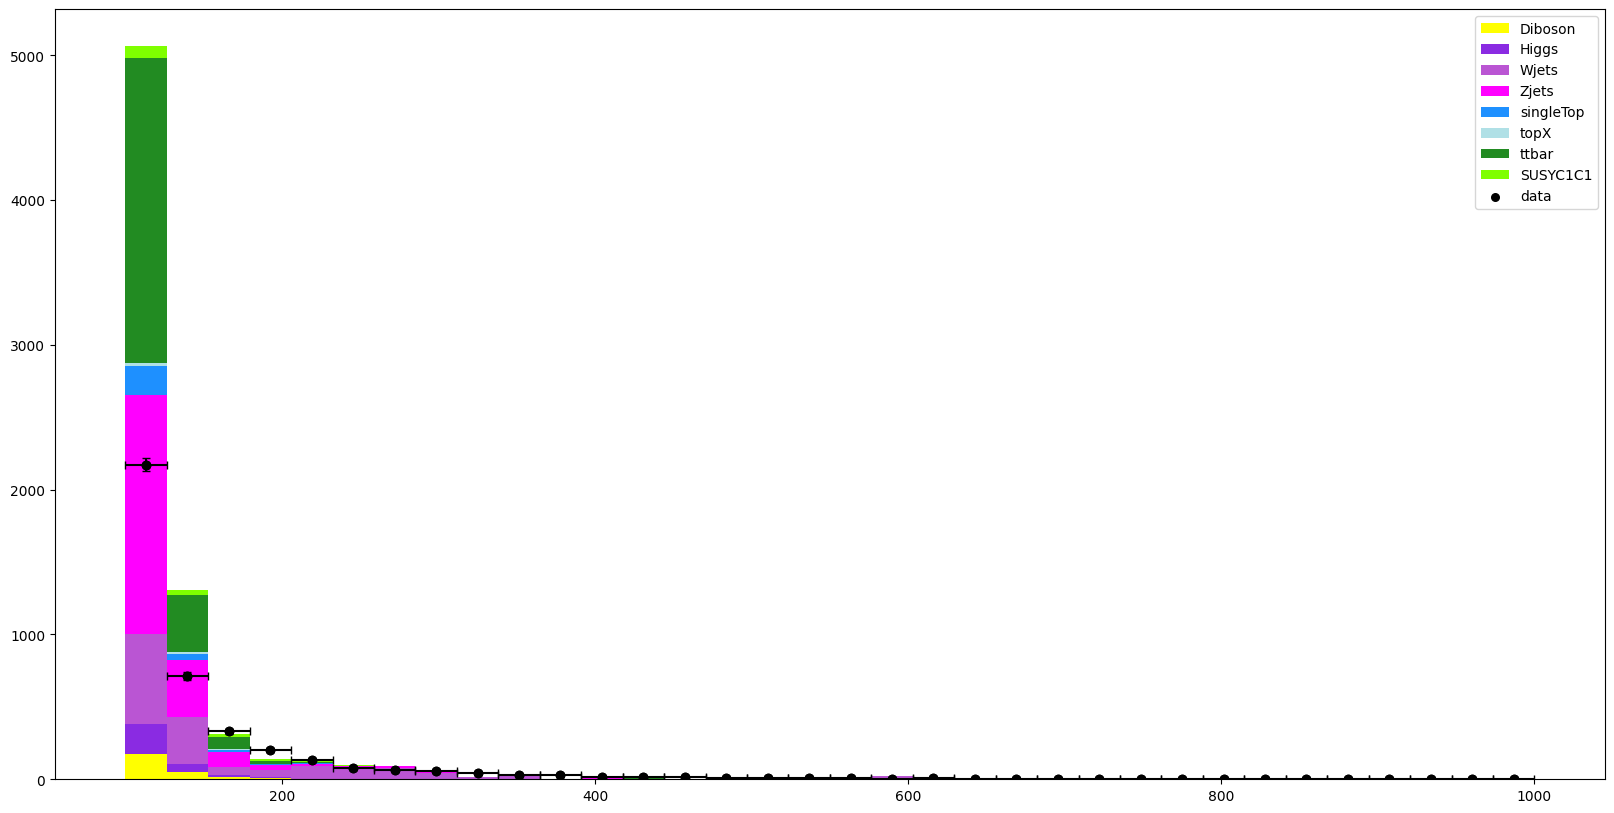

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
theRange = (100,1000)
nbins = 34
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(tuple(bkgArrays),
         weights=tuple(weightArrays),
         bins=nbins, 
         range=theRange, 
         color=list(processes.values()), 
         label=list(processes.keys()),
         #density=True,
         stacked=True)

# Calculate the histogram bin edges and bin counts
n, bins = np.histogram(dataArray, bins=nbins,range=theRange)

# Calculate the bin centers
bin_centers = 0.5 * (bins[1:] + bins[:-1])

bin_xerr = np.zeros((len(bins)-1))
bin_yerr = np.zeros((len(bins)-1))
for i in range(len(bins)-1):
    bin_xerr[i] = 0.5*(bins[i+1]-bins[i])
    if n[i]:
        bin_yerr[i] = np.sqrt(n[i])

# Plot the markers
plt.scatter(bin_centers, n, color='black', marker='o', s=30, label='data')
plt.errorbar(bin_centers, n, xerr=bin_xerr, linestyle='none', marker='o', capsize=3, color='black')
plt.errorbar(bin_centers, n, yerr=bin_yerr, linestyle='none', marker='o', capsize=3, color='black')
#plt.yscale('log')
plt.legend()
plt.show()

## Dump content to HDF5
Dump the content of the arrays to HDF5. If you are running with doDask true, the computational graphs built above will be executed here and the full data processing will be done. If false then the arrays are already filled and the HDF5 writing will be the only thing that is done here.
Re-import awkward explicitly, as the Pandas-related operations aren't defined for Dask-Awkward.

In [32]:
import awkward as awkward

start = time.time()


outputPath = "./results/"
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

if doDask:

    arraysForEvaluation = []

    for process in requiredProcesses:
        for result in selection[process].keys():
            if result[0] == "2L": continue
            arraysForEvaluation.append(selection[process][result])
            
    print("Number of arrays to evaluate = ",len(arraysForEvaluation))

    # Evaluate the arrays
    evaluated = dask.compute(arraysForEvaluation)
    index = 0
    # Extract the data and write to output
    for process in requiredProcesses:
        fname = outputPath+process+".hdf5"
        if os.path.exists(fname):
            os.remove(fname)
        dataframes = {}
        for result in selection[process].keys():
            if result[0] == "2L": continue
            channel = result[0]
            columnName = result[1]
            if channel not in dataframes.keys(): dataframes[channel] = pd.DataFrame()
            dataframes[channel][columnName] = awkward.to_dataframe(evaluated[0][index])
            index = index + 1
        for channel in dataframes.keys():
            dataframes[channel].to_hdf("%s"%fname,"mini")
        del dataframes
# Non-dask case: arrays will already have been evaluated so just a case of writing the output
else:
    for process in requiredProcesses:
        print(process)
        fname = outputPath+process +".hdf5"
        if os.path.exists(fname):
            os.remove(fname)
        dataframes = {}
        for result in selection[process].keys():
            print(result[0],result[1])
            channel = result[0]
            columnName = result[1]
            if channel == "2L": continue
            if channel not in dataframes.keys(): dataframes[channel] = pd.DataFrame()
            dataframes[channel][columnName] = awkward.to_dataframe(selection[process][result])
        for channel in dataframes.keys():
            dataframes[channel].to_hdf("%s"%fname,"mini")
        del dataframes
        #break
            
end = time.time()

print("Time taken to execute = ",end-start)

Diboson
2L channel_nr
2L type
2L et
2L phi
2L jet_n
2L sig_el
2L sig_mu
2L n_el
2L n_mu
2L n_lep
2L n_lep == 2
2L scalef
2L n_el == 2
2L n_mu == 2
2L n_mu == 1 && n_el == 1
2L lep1_pt
2L lep2_pt
2L lep1_eta
2L lep2_eta
2L lep1_phi
2L lep2_phi
2L lep1_ch
2L lep2_ch
2L lep1_type
2L lep2_type
2L lep1_mass
2L lep2_mass
2L ev_mll
2L met_pt
2L met_phi
2L ev_mt2
Higgs
2L channel_nr
2L type
2L et
2L phi
2L jet_n
2L sig_el
2L sig_mu
2L n_el
2L n_mu
2L n_lep
2L n_lep == 2
2L scalef
2L n_el == 2
2L n_mu == 2
2L n_mu == 1 && n_el == 1
2L lep1_pt
2L lep2_pt
2L lep1_eta
2L lep2_eta
2L lep1_phi
2L lep2_phi
2L lep1_ch
2L lep2_ch
2L lep1_type
2L lep2_type
2L lep1_mass
2L lep2_mass
2L ev_mll
2L met_pt
2L met_phi
2L ev_mt2
Wjets
2L channel_nr
2L type
2L et
2L phi
2L jet_n
2L sig_el
2L sig_mu
2L n_el
2L n_mu
2L n_lep
2L n_lep == 2
2L scalef
2L n_el == 2
2L n_mu == 2
2L n_mu == 1 && n_el == 1
2L lep1_pt
2L lep2_pt
2L lep1_eta
2L lep2_eta
2L lep1_phi
2L lep2_phi
2L lep1_ch
2L lep2_ch
2L lep1_type
2L lep2_ty

In [30]:
# Quick check that everything worked...
reread = pd.read_hdf('./results/Diboson.hdf5')
print("Number of rows in the output HDF5 file = ",reread.shape[0])    
reread.head()

FileNotFoundError: File ./results/Diboson.hdf5 does not exist

In [59]:
import glob
glob.glob("./results/*")

[]